## 002 Run

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../../')
# keras expects data to be encoded in a particular way, to_categorical does this encoding for us (one-hot encoding)
from keras.utils.np_utils import to_categorical
import libs.importing as importing
import pandas as pd
import os
import libs.render as render
import libs.cnn_models as cnn_models
import libs.analysis as analysis
import libs.normalization as normalization
from importlib import reload
import libs.data_prep as data_prep
import numpy as np
from keras.models import load_model

from pylab import rcParams
rcParams['figure.figsize'] = (10,8)

In [3]:
# LOAD PATCH DATA REFERENCES

# directory setup
data_source = '../a2aaceaa'
train_dir = os.path.join(data_source, 'train')
test_dir = os.path.join(data_source, 'test')
val_dir = os.path.join(data_source, 'val')

# get references to the data we want
train_patches_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'))
train_data_reader = importing.PatchDataReader(os.path.join(train_dir, 'patches'), train_patches_df)

test_patches_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'))
test_data_reader = importing.PatchDataReader(os.path.join(test_dir, 'patches'), test_patches_df)

val_patches_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'))
val_data_reader = importing.PatchDataReader(os.path.join(val_dir, 'patches'), val_patches_df)

In [4]:
## READ PATCH DATA

# load train, test, and validation data
x_train, y_train = train_data_reader.read_data()
x_test, y_test = test_data_reader.read_data()
x_val, y_val = val_data_reader.read_data()

# LOG RESULTS
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_data_reader)
data_prep.log_patch_data_reader(test_dir, test_data_reader)
data_prep.log_patch_data_reader(val_dir, val_data_reader)

In [19]:
# INSPECT : look at class 1 = benign and 2 = papilloma, 3 = dysplasia+carcinoma

#render.plot_image(x_train[0])
#print(y_train[122])

#render.plot_image(x_train[2])
#print(y_train[2])

#render.plot_image(x_train[8])
#print(y_train[8])


In [5]:
## CONVERT CLASSES TO KERAS FORMAT
# keras expects classes to be number from 0-N, we are using 1-N numbering so we need to convert.
# then we also have to change the classes to one-hot encoding

y_train_oh = to_categorical(y_train - 1)
y_test_oh  = to_categorical(y_test - 1)
y_val_oh   = to_categorical(y_val - 1)

In [6]:
# NORMALIZATION

m, std = normalization.dataset_mean_and_std(x_train)

x_train = (x_train - m) / std
x_test  = (x_test - m) / std
x_val   = (x_val - m) / std

In [11]:
## MODEL : load from file, show summary, and compile
reload(cnn_models)

model = cnn_models.model_from_previous_research_dropout(num_classes=4)
display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 192)       196800    
_________________________________________________________________
activation_10 (Activation)   (None, 15, 15, 192)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 192)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 192)         0         
__________

None

In [8]:
data_prep.check_for_nans(x_train)
data_prep.check_for_nans(x_test)
data_prep.check_for_nans(x_val)

print(y_train[:100], y_test[:100], y_val[:100])

[4 4 2 2 4 3 2 4 4 1 1 4 4 3 1 3 4 1 4 4 2 2 4 4 4 1 4 4 3 4 4 2 2 4 4 4 4
 1 2 1 1 1 4 1 2 1 4 4 4 4 4 4 3 2 4 3 4 1 1 2 1 4 1 4 4 1 4 1 4 4 1 4 4 1
 4 4 4 1 4 4 1 4 4 4 4 4 4 1 1 2 2 2 4 4 1 4 4 1 2 1] [4 4 1 3 2 4 4 4 4 4 3 1 4 3 3 2 1 3 3 1 2 3 3 1 3 4 1 3 3 2 2 3 2 1 2 3 3
 4 1 2 4 3 4 4 3 1 3 2 4 3 1 1 3 4 1 3 4 3 3 1 3 4 4 3 3 3 4 1 4 1 1 1 3 3
 4 4 3 3 3 3 2 1 2 3 2 3 3 2 1 3 3 1 3 4 3 1 3 3 4 3] [4 1 1 1 1 1 1 4 2 4 4 1 1 4 1 4 4 4 2 4 2 4 4 1 1 1 1 3 4 1 4 3 3 2 4 4 3
 2 4 1 1 4 4 1 1 1 4 1 4 4 1 1 1 4 3 2 2 1 2 4 4 4 1 3 4 4 3 4 4 3 3 1 4 3
 1 1 1 1 1 1 1 4 1 4 4 1 4 4 4 1 2 2 4 4 4 1 1 4 1 1]


In [13]:
## Now Let's do a run with data augmentation
reload(cnn_models)
from keras.preprocessing.image import ImageDataGenerator

# parameters
epochs = 20
batch_size = 32

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=30,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                     # Randomly zoom image 
        width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=False)                  # randomly flip images


#datagen.fit(x_train)


#history = model.fit_generator(datagen.flow(x_train,y_train_oh, batch_size=batch_size),
#                              epochs = epochs, validation_data = (x_test,y_test_oh),
#                              workers = 4,
#                              verbose = 1, steps_per_epoch = x_train.shape[0] # batch_size
#                              , callbacks=[cnn_models.annealer()])


history = model.fit(x_train,y_train_oh, batch_size=batch_size,
                              epochs = epochs,
                              validation_data = (x_test,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[cnn_models.annealer(2)])

Train on 4402 samples, validate on 419 samples
Epoch 1/20
4402/4402 [==============================] - 14s 3ms/step - loss: 0.8488 - acc: 0.7233 - val_loss: 1.9211 - val_acc: 0.3723
Epoch 2/20
4402/4402 [==============================] - 14s 3ms/step - loss: 0.8119 - acc: 0.7292 - val_loss: 1.8060 - val_acc: 0.3532
Epoch 3/20
4402/4402 [==============================] - 14s 3ms/step - loss: 0.8094 - acc: 0.7263 - val_loss: 1.5538 - val_acc: 0.3675
Epoch 4/20
4402/4402 [==============================] - 13s 3ms/step - loss: 0.7849 - acc: 0.7324 - val_loss: 1.7244 - val_acc: 0.3747
Epoch 5/20
4402/4402 [==============================] - 13s 3ms/step - loss: 0.7664 - acc: 0.7413 - val_loss: 2.2530 - val_acc: 0.4368
Epoch 6/20
4402/4402 [==============================] - 13s 3ms/step - loss: 0.8017 - acc: 0.7340 - val_loss: 2.2029 - val_acc: 0.3532
Epoch 7/20
4402/4402 [==============================] - 13s 3ms/step - loss: 0.7729 - acc: 0.7376 - val_loss: 1.9100 - val_acc: 0.3771
Epoch 8/

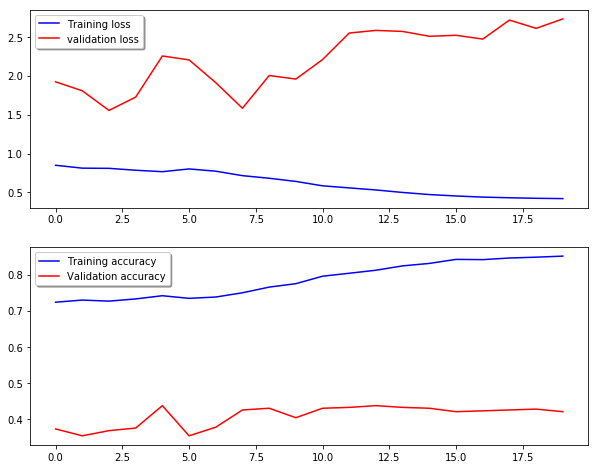

Precision (specificity): 46.361%
Recall (sensitivity): 47.311%
Accuracy: 68.619%
F1: 45.646%


In [14]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [15]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))
analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))

hgv-dffcce57 [0.07592348 0.32263526 0.20787354 0.39356774] 3
mdi-461bdebc [0.785109   0.00750954 0.04465769 0.1627238 ] 0
odi-28084697 [0.82264113 0.02468258 0.06156695 0.09110933] 2
hgv-2cdb69f6 [0.00920114 0.1582242  0.10933761 0.723237  ] 2
mdi-b731a91f [0.0311133  0.03975619 0.05740392 0.87172645] 3
hgv-99fc12a1 [0.21405114 0.2529197  0.2675477  0.26548147] 1
odi-bf734aed [0.06100189 0.14551224 0.13535923 0.6581266 ] 1
odi-1767f1a2 [0.7426491  0.07673678 0.1637923  0.01682194] 0


In [16]:
model.save('model_002.h5')

In [20]:
reload(cnn_models)

model = cnn_models.model_from_previous_research_dropout(num_classes=4)
#display(model.summary())

# parameters:
learning_rate = 1e-2

model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=["accuracy"])

# parameters
epochs = 8
batch_size = 16

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=30,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                     # Randomly zoom image 
        width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=False)                  # randomly flip images


datagen.fit(x_train)


history = model.fit_generator(datagen.flow(x_train,y_train_oh, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test_oh),
                              workers = 4,
                              verbose = 1, steps_per_epoch = x_train.shape[0] # batch_size
                              , callbacks=[cnn_models.annealer()])

#history = model.fit(x_train,y_train_oh, batch_size=batch_size,
#                              epochs = epochs,
#                              validation_data = (x_test,y_test_oh), shuffle=True,
#                              verbose = 1, callbacks=[cnn_models.annealer(1)])

Epoch 1/8
4402/4402 [==============================] - 427s 97ms/step - loss: 0.7760 - acc: 0.7354 - val_loss: 1.8851 - val_acc: 0.4081
Epoch 2/8
4402/4402 [==============================] - 425s 97ms/step - loss: 0.6539 - acc: 0.7678 - val_loss: 2.3792 - val_acc: 0.4200
Epoch 3/8
4402/4402 [==============================] - 425s 97ms/step - loss: 0.6057 - acc: 0.7873 - val_loss: 2.2446 - val_acc: 0.3986
Epoch 4/8
4402/4402 [==============================] - 425s 97ms/step - loss: 0.5507 - acc: 0.8045 - val_loss: 3.5034 - val_acc: 0.3747
Epoch 5/8
4402/4402 [==============================] - 425s 97ms/step - loss: 0.5146 - acc: 0.8168 - val_loss: 2.7033 - val_acc: 0.3461
Epoch 6/8
 871/4402 [====>.........................] - ETA: 5:40 - loss: 0.5050 - acc: 0.8216

KeyboardInterrupt: 

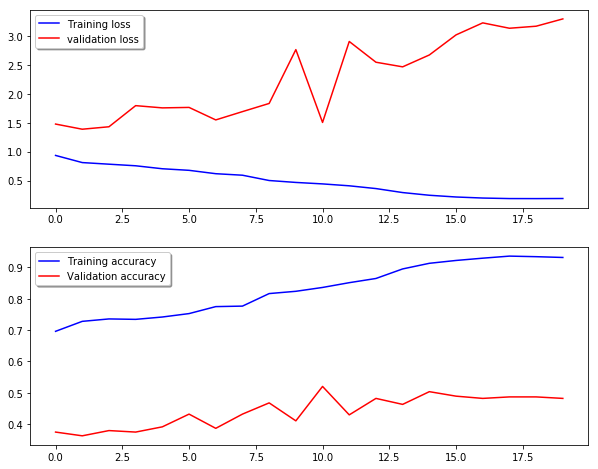

Precision (specificity): 65.414%
Recall (sensitivity): 59.476%
Accuracy: 72.385%
F1: 58.549%


In [18]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [20]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))
analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))

hgv-dffcce57 [1.0767709e-06 5.8119136e-01 1.3199821e-02 4.0560773e-01] 3
mdi-461bdebc [7.0221287e-01 5.6243758e-04 4.9020037e-02 2.4820463e-01] 0
odi-28084697 [0.64524466 0.01338787 0.1376137  0.20375378] 2
hgv-2cdb69f6 [0.00089078 0.16741805 0.12738459 0.70430654] 2
mdi-b731a91f [1.505135e-04 1.636913e-02 4.578061e-02 9.376997e-01] 3
hgv-99fc12a1 [6.0903189e-05 9.0315056e-01 1.2687952e-03 9.5519722e-02] 1
odi-bf734aed [6.8770443e-09 6.3665503e-01 1.6703753e-04 3.6317790e-01] 1
odi-1767f1a2 [7.5570661e-01 2.8808698e-02 2.1473643e-01 7.4816548e-04] 0


In [21]:
model.save('model_001_r2.h5')

In [23]:
reload(cnn_models)

model = cnn_models.model_3layer(num_classes=4)
#display(model.summary())

# parameters:
learning_rate = 1e-3

model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=["accuracy"])

# parameters
epochs = 5
batch_size = 32

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=30,                    # randomly rotate images in the range (degrees, 0 to 180)
        #zoom_range = 0.1,                     # Randomly zoom image 
        width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=False)                  # randomly flip images


datagen.fit(x_train)


history = model.fit_generator(datagen.flow(x_train,y_train_oh, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test_oh),
                              workers = 4,
                              verbose = 1, steps_per_epoch = x_train.shape[0] # batch_size
                              , callbacks=[cnn_models.annealer(2)])

#history = model.fit(x_train,y_train_oh, batch_size=batch_size,
#                              epochs = epochs,
#                              validation_data = (x_test,y_test_oh), shuffle=True,
#                              verbose = 1, callbacks=[cnn_models.annealer(2)])

Epoch 1/5
4402/4402 [==============================] - 390s 88ms/step - loss: 0.6539 - acc: 0.7631 - val_loss: 2.1805 - val_acc: 0.3866
Epoch 2/5
4402/4402 [==============================] - 388s 88ms/step - loss: 0.4262 - acc: 0.8354 - val_loss: 2.9314 - val_acc: 0.4010
Epoch 3/5
4402/4402 [==============================] - 388s 88ms/step - loss: 0.3244 - acc: 0.8768 - val_loss: 3.1670 - val_acc: 0.4391
Epoch 4/5
4402/4402 [==============================] - 388s 88ms/step - loss: 0.2741 - acc: 0.8971 - val_loss: 3.8977 - val_acc: 0.3604
Epoch 5/5
4402/4402 [==============================] - 387s 88ms/step - loss: 0.3208 - acc: 0.8876 - val_loss: 4.6348 - val_acc: 0.3508


In [3]:
model = load_model('model_001_r3.h5')

ResourceExhaustedError: OOM when allocating tensor of shape [4096,4096] and type float
	 [[Node: training/Adam/zeros_12 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [4096,4096] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'training/Adam/zeros_12', defined at:
  File "/home/che/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/che/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/che/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/che/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/che/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/che/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/che/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/che/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/che/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/che/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/che/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/che/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/che/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/che/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/che/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/che/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/che/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/che/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/che/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/che/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-79b455e4f859>", line 1, in <module>
    model = load_model('model_001_r3.h5')
  File "/home/che/anaconda3/lib/python3.6/site-packages/keras/models.py", line 280, in load_model
    model.model._make_train_function()
  File "/home/che/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "/home/che/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/che/anaconda3/lib/python3.6/site-packages/keras/optimizers.py", line 457, in get_updates
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/che/anaconda3/lib/python3.6/site-packages/keras/optimizers.py", line 457, in <listcomp>
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/che/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 692, in zeros
    v = tf.zeros(shape=shape, dtype=tf_dtype, name=name)
  File "/home/che/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1606, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/home/che/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2583, in fill
    "Fill", dims=dims, value=value, name=name)
  File "/home/che/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/che/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3327, in create_op
    op_def=op_def)
  File "/home/che/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1674, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [4096,4096] and type float
	 [[Node: training/Adam/zeros_12 = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [4096,4096] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


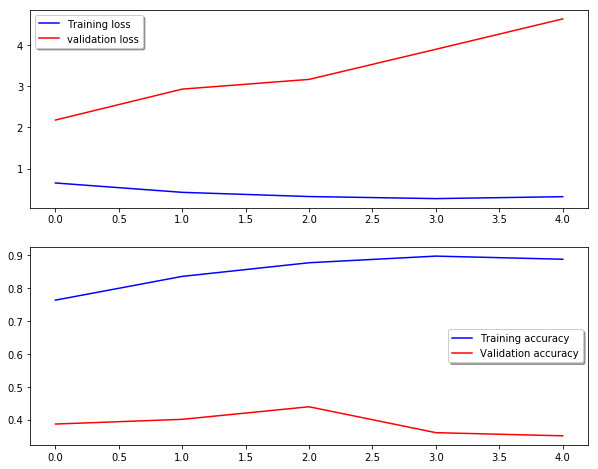

Precision (specificity): 64.719%
Recall (sensitivity): 61.408%
Accuracy: 75.314%
F1: 58.609%


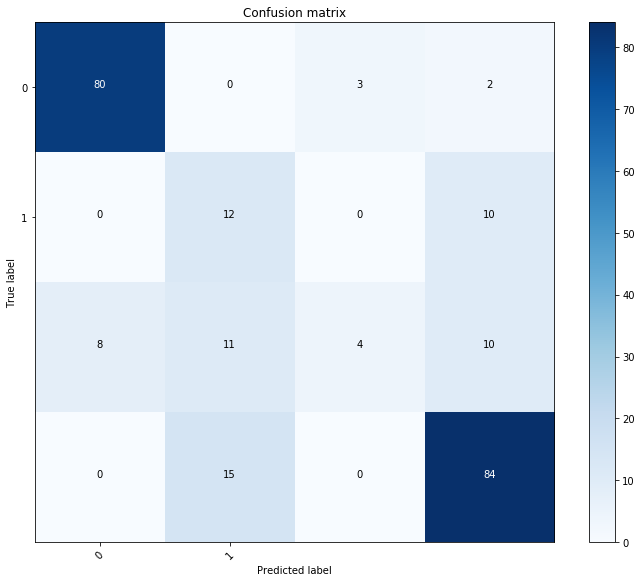

In [24]:
#render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=4)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [25]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))
analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))

hgv-dffcce57 [0.00446146 0.39059702 0.00714138 0.59780014] 3
mdi-461bdebc [0.8607705  0.00267827 0.00814145 0.12840968] 0
odi-28084697 [0.5688147  0.01483483 0.3365052  0.07984526] 2
hgv-2cdb69f6 [0.01998676 0.44357368 0.03212716 0.5043124 ] 2
mdi-b731a91f [2.5286257e-02 7.8118166e-05 4.5467120e-02 9.2916840e-01] 3
hgv-99fc12a1 [0.06747266 0.42647278 0.00652795 0.49952653] 1
odi-bf734aed [1.4937337e-04 5.9789139e-01 1.9349665e-03 4.0002429e-01] 1
odi-1767f1a2 [8.9135802e-01 1.0024855e-02 9.8455340e-02 1.6179608e-04] 0


In [26]:
model.save('model_001_r3.h5')

In [7]:
## FIXES:

model = load_model('model_001_r3.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_41 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 64, 64, 48)        27696     
_________________________________________________________________
activation_42 (Activation)   (None, 64, 64, 48)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 48)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 128)       55424     
__________

Precision (specificity): 64.719%
Recall (sensitivity): 61.408%
Accuracy: 75.314%
F1: 58.609%


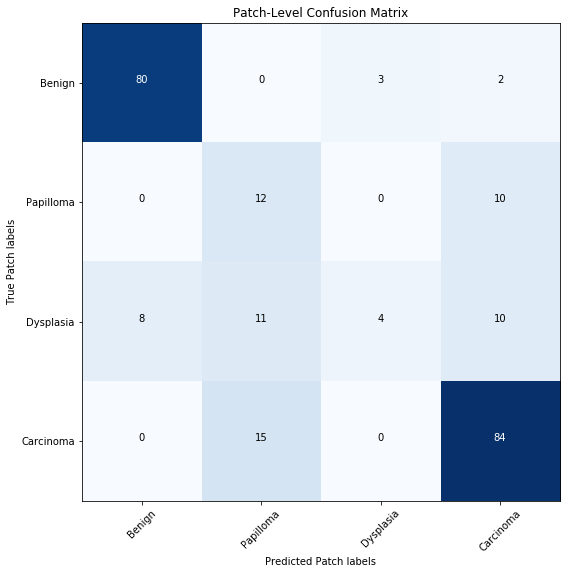

In [8]:
reload(analysis)
reload(render)
from pylab import rcParams
rcParams['figure.figsize'] = (8, 8) # constant figure size

## PATCH LEVEL STATISTICS

# predictions
y_pred_oh = model.predict(x_val)
cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix_fix(cm, num_classes=4,
                                 labels=['Benign', 'Papilloma', 'Dysplasia', 'Carcinoma'], 
                                 stat_type='patch', save='exp6_patch_level_cm')

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [10]:
## ROI Level Statistics
reload(analysis)
reload(render)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))

preds, truths = analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))
#print(preds, truths)
cm = analysis.roi_cm(truths, preds, num_classes=4)
cm_norm = analysis.normalize_roi_cm(cm)

analysis.roi_stats_4class(cm_norm)

hgv-dffcce57 [0.00446146 0.39059702 0.00714138 0.59780014] 3
mdi-461bdebc [0.8607705  0.00267827 0.00814145 0.12840968] 0
odi-28084697 [0.5688147  0.01483483 0.3365052  0.07984526] 2
hgv-2cdb69f6 [0.01998913 0.44356564 0.0321291  0.5043161 ] 2
mdi-b731a91f [2.5286257e-02 7.8118166e-05 4.5467120e-02 9.2916840e-01] 3
hgv-99fc12a1 [0.06747266 0.42647278 0.00652795 0.49952653] 1
odi-bf734aed [1.4937337e-04 5.9789139e-01 1.9349665e-03 4.0002429e-01] 1
odi-1767f1a2 [8.9135802e-01 1.0024855e-02 9.8455340e-02 1.6179608e-04] 0
Precision (specificity): 58.401%
Recall (sensitivity): 60.885%
Accuracy: 58.401%
